### Libraries

In [1]:
import contextily as cx
from ipywidgets import interact
from math import floor
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from pyrsgis import raster
from pyrsgis.convert import array_to_table
from pyrsgis.ml import imageChipsFromArray
import random
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential

### Loading the multispectral image

In [2]:
# file names
feature_file = './BrokenHill_Landsat8.tif'

# read the image
dsFeatures, arrFeatures = raster.read(feature_file, bands='all')
arrFeatures = arrFeatures.astype(float)
# arrFeatures = np.float16(arrFeatures)

# dsFeatures.__dict__

min_x = dsFeatures.bbox[0][0]
max_x = dsFeatures.bbox[1][0]
min_y = dsFeatures.bbox[0][1]
max_y = dsFeatures.bbox[1][1]

extent = [min_x, max_x, min_y, max_y]

### Visualizing spectral bands

In [3]:
def plot_array_stretched(array, label, n):
    fig, ax = plt.subplots(figsize=(10, 10))
    v_mean = np.array(np.nanmean(array))
    v_std = np.array(np.nanstd(array))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
    plt.yticks(rotation=90, va='center')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
    cb = ax.imshow(array, cmap='Greys_r', extent=extent, vmin=v_mean-(n*v_std), vmax=v_mean+(n*v_std))
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    plt.colorbar(cb, orientation='horizontal', label=label, cax=cax)
    plt.grid(False)
    plt.show()

def plot_array(array, label):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
    plt.yticks(rotation=90, va='center')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
    cb = ax.imshow(array, cmap='Greys_r', extent=extent)
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    plt.colorbar(cb, orientation='horizontal', label=label, cax=cax)
    plt.grid(False)
    plt.show()

@interact(band=range(1, arrFeatures.shape[0]+1))
def show_dist(band):
    plot_array_stretched(arrFeatures[band-1, :, :], f'Band {band}', 3)

interactive(children=(Dropdown(description='band', options=(1, 2, 3, 4, 5, 6, 7), value=1), Output()), _dom_cl…

### Normalizing

In [4]:
arrFeatures = array_to_table(arrFeatures)
arrFeatures_fuzzy = np.zeros(arrFeatures.shape)

# normalize the image
for i in range(arrFeatures.shape[1]):
    bandMin = arrFeatures[:, i].min()
    bandMax = arrFeatures[:, i].max()
    bandRange = bandMax-bandMin
    for j in range(arrFeatures.shape[0]):
        arrFeatures_fuzzy[j, i] = (arrFeatures[j, i]-bandMin)/bandRange

### Loading the training dataset (manual)

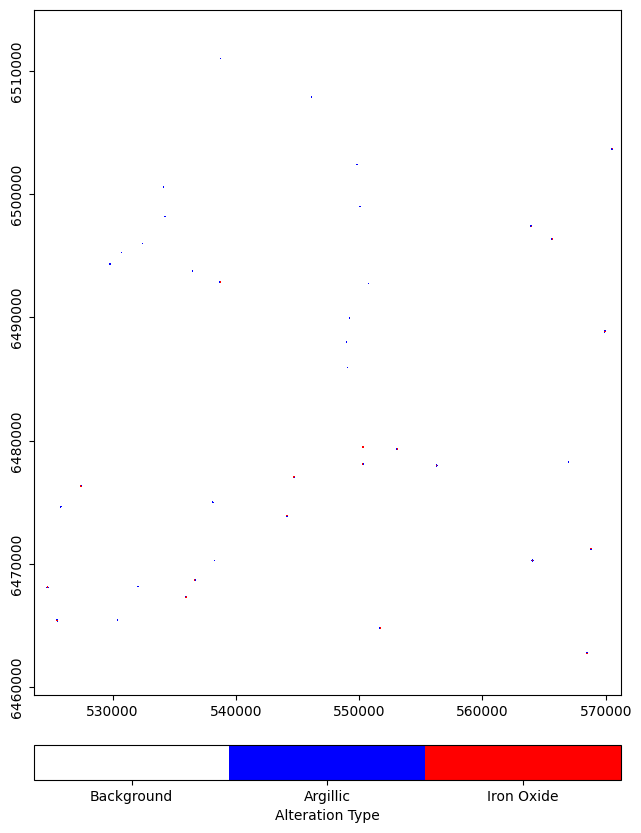

In [5]:
positiveLabel_file = './BrokenHill_Landsat8_Manual_CombinedTraining.tif'
# read and reshape the label file
dsPositiveLabels, arrPositiveLabels = raster.read(positiveLabel_file)
n_class_pos = len(np.unique(arrPositiveLabels))

fig, ax = plt.subplots(figsize=(10, 10))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
cmap = mpl.colors.ListedColormap(['white', 'blue', 'red'])
image = plt.imshow(arrPositiveLabels, cmap=cmap, extent=extent)
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
cbar = plt.colorbar(image, orientation='horizontal', label='Alteration Type', cax=cax)
tick_locs = (np.arange(n_class_pos) + 0.5)*(n_class_pos-1)/n_class_pos
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(['Background', 'Argillic', 'Iron Oxide'])
plt.grid(False)

### Generating random samples

In [6]:
# generate random samples
nonZero_count = np.count_nonzero(arrPositiveLabels)
index = np.transpose(np.where(arrPositiveLabels==0))
index = index.astype(int)
randomIndex = random.sample(range(index.shape[0]), int(nonZero_count/(n_class_pos-1)))
arrNegativeLabels = np.zeros(arrPositiveLabels.shape)

for i in range(len(randomIndex)):
    arrNegativeLabels[index[randomIndex[i], 0], index[randomIndex[i], 1]] = n_class_pos # max value of labels plus one which equals n_class
    
arrPositiveLabels_flat = arrPositiveLabels.flatten()
arrNegativeLabels_flat = arrNegativeLabels.flatten()
# separate and balance the classes
positiveFeatures = arrFeatures_fuzzy[arrPositiveLabels_flat!=0]
positiveLabels = arrPositiveLabels_flat[arrPositiveLabels_flat!=0]
negativeFeatures = arrFeatures_fuzzy[arrNegativeLabels_flat==n_class_pos]
negativeLabels = arrNegativeLabels_flat[arrNegativeLabels_flat==n_class_pos]
# combine the balanced features
features = np.concatenate((positiveFeatures, negativeFeatures), axis=0)
labels = np.concatenate((positiveLabels, negativeLabels), axis=0)
# call the function to split the dataset
train_x, train_y, test_x, test_y = train_test_split(features, labels, train_size=0.7)

### Training the model using MLP

In [9]:
# # create the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(6, activation='selu', input_shape=(train_x.shape[1], )))
model.add(tf.keras.layers.Dense(5, activation='selu'))
model.add(tf.keras.layers.Dense(4, activation='softmax'))

# print(model.summary())

# run the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.fit(train_x, test_x, epochs=80)
# predict for the test dataset
yTestPredicted = model.predict(train_y)
# calculate and display error metrics
yTestPredicted_ = yTestPredicted.argmax(axis=1)

cMatrix = confusion_matrix(test_y, yTestPredicted_)
pScore = precision_score(test_y, yTestPredicted_, average='micro')
rScore = recall_score(test_y, yTestPredicted_, average='micro')
fscore = f1_score(test_y, yTestPredicted_, average='micro')

print("Confusion matrix:\n", cMatrix)
print("\nP-Score: %.3f, R-Score: %.3f, F-Score: %.3f" % (pScore, rScore, fscore))

Epoch 1/80
33/33 [==============================] - 1s 1ms/step - loss: 1.4493 - accuracy: 0.3267
Epoch 2/80
33/33 [==============================] - 0s 819us/step - loss: 1.3136 - accuracy: 0.2676
Epoch 3/80
33/33 [==============================] - 0s 902us/step - loss: 1.2391 - accuracy: 0.1971
Epoch 4/80
33/33 [==============================] - 0s 982us/step - loss: 1.1807 - accuracy: 0.3333
Epoch 5/80
33/33 [==============================] - 0s 1ms/step - loss: 1.1486 - accuracy: 0.3333
Epoch 6/80
33/33 [==============================] - 0s 1ms/step - loss: 1.1328 - accuracy: 0.3333
Epoch 7/80
33/33 [==============================] - 0s 1ms/step - loss: 1.1229 - accuracy: 0.3190
Epoch 8/80
33/33 [==============================] - 0s 911us/step - loss: 1.1163 - accuracy: 0.3057
Epoch 9/80
33/33 [==============================] - 0s 871us/step - loss: 1.1111 - accuracy: 0.2638
Epoch 10/80
33/33 [==============================] - 0s 1ms/step - loss: 1.1072 - accuracy: 0.3095
Epoch 11/

### Mapping alteration zones

91947/91947 [==============================] - 98s 1ms/step


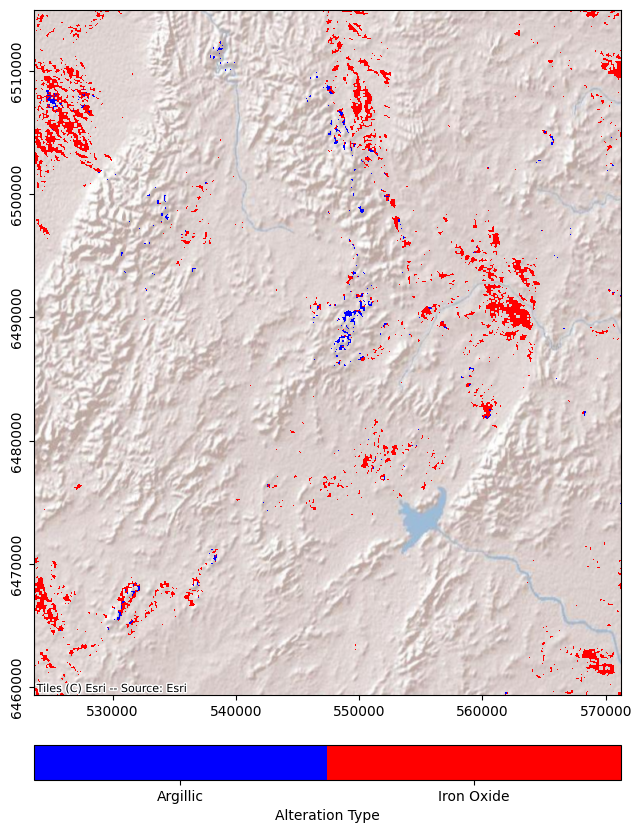

In [10]:
# load and normalize a new multispectral image
dsPred, arrPred = raster.read('./BrokenHill_Landsat8.tif')
arrPred = arrPred.astype(float)
# arrPred = np.float16(arrPred)
arrPred = array_to_table(arrPred)
arrPred_fuzzy = np.zeros(arrPred.shape)

# normalize the image
for i in range(arrPred.shape[1]):
    bandMin = arrPred[:, i].min()
    bandMax = arrPred[:, i].max()
    bandRange = bandMax-bandMin
    for j in range(arrPred.shape[0]):
        arrPred_fuzzy[j, i] = (arrPred[j, i]-bandMin)/bandRange

# predict and export the probability raster
pred = model.predict(arrPred_fuzzy)
pred_array = np.reshape(pred.argmax(axis=1), (dsPred.RasterYSize, dsPred.RasterXSize))

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)
cx.add_basemap(ax, crs='EPSG:32754', source=cx.providers.Esri.WorldShadedRelief)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
cmap = mpl.colors.ListedColormap(['blue', 'red'])

pred_array_copy = pred_array.copy()
pred_array_copy = pred_array_copy.astype('float')
pred_array_copy[pred_array_copy==3] = float('nan')
image = plt.imshow(pred_array_copy, cmap=cmap, extent=extent)

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
cbar = plt.colorbar(image, orientation='horizontal', label='Alteration Type', cax=cax)
tick_locs = (np.arange(n_class_pos-1) + 2.5)*(n_class_pos-2)/(n_class_pos-1)
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(['Argillic', 'Iron Oxide'])
plt.grid(False)

# outFile = './BrokenHill_Landsat8_Manual_MLP_AlterationMap.tif'
# raster.export(pred_array, dsPred, filename=outFile, dtype='float')

### Training the model using SVM

In [11]:
model = SVC()
model.fit(train_x, test_x)
# predict for the test dataset
yTestPredicted = model.predict(train_y)
# calculate and display error metrics
cMatrix = confusion_matrix(test_y, yTestPredicted)
pScore = precision_score(test_y, yTestPredicted, average='micro')
rScore = recall_score(test_y, yTestPredicted, average='micro')
fscore = f1_score(test_y, yTestPredicted, average='micro')

print("Confusion matrix:\n", cMatrix)
print("\nP-Score: %.3f, R-Score: %.3f, F-Score: %.3f" % (pScore, rScore, fscore))

Confusion matrix:
 [[143   1   6]
 [  0 138   7]
 [  6  19 130]]

P-Score: 0.913, R-Score: 0.913, F-Score: 0.913


### Mapping alteration zones

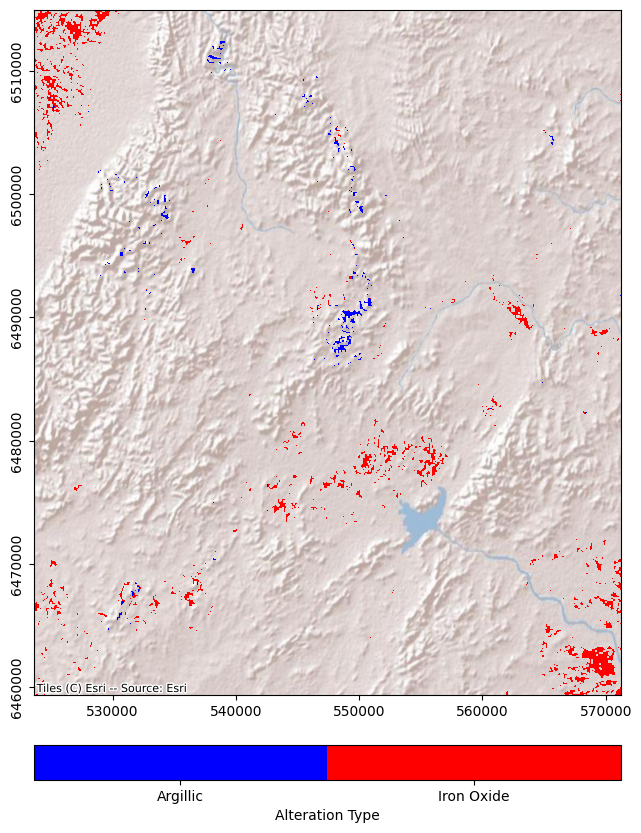

In [12]:
# load and normalize a new multispectral image
dsPred, arrPred = raster.read('./BrokenHill_Landsat8.tif')
arrPred = arrPred.astype(float)
# arrPred = np.float16(arrPred)
arrPred = array_to_table(arrPred)
arrPred_fuzzy = np.zeros(arrPred.shape)

# normalize the image
for i in range(arrPred.shape[1]):
    bandMin = arrPred[:, i].min()
    bandMax = arrPred[:, i].max()
    bandRange = bandMax-bandMin
    for j in range(arrPred.shape[0]):
        arrPred_fuzzy[j, i] = (arrPred[j, i]-bandMin)/bandRange

# predict and export the probability raster
pred = model.predict(arrPred_fuzzy)
pred_array = np.reshape(pred, (dsPred.RasterYSize, dsPred.RasterXSize))

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)
cx.add_basemap(ax, crs='EPSG:32754', source=cx.providers.Esri.WorldShadedRelief)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
cmap = mpl.colors.ListedColormap(['blue', 'red'])

pred_array_copy = pred_array.copy()
pred_array_copy = pred_array_copy.astype('float')
pred_array_copy[pred_array_copy==3] = float('nan')
image = plt.imshow(pred_array_copy, cmap=cmap, extent=extent)

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
cbar = plt.colorbar(image, orientation='horizontal', label='Alteration Type', cax=cax)
tick_locs = (np.arange(n_class_pos-1) + 2.5)*(n_class_pos-2)/(n_class_pos-1)
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(['Argillic', 'Iron Oxide'])
plt.grid(False)

# outFile = './BrokenHill_Landsat8_Manual_SVM_AlterationMap.tif'
# raster.export(pred_array, dsPred, filename=outFile, dtype='float')

### Loading the training dataset (PCA)

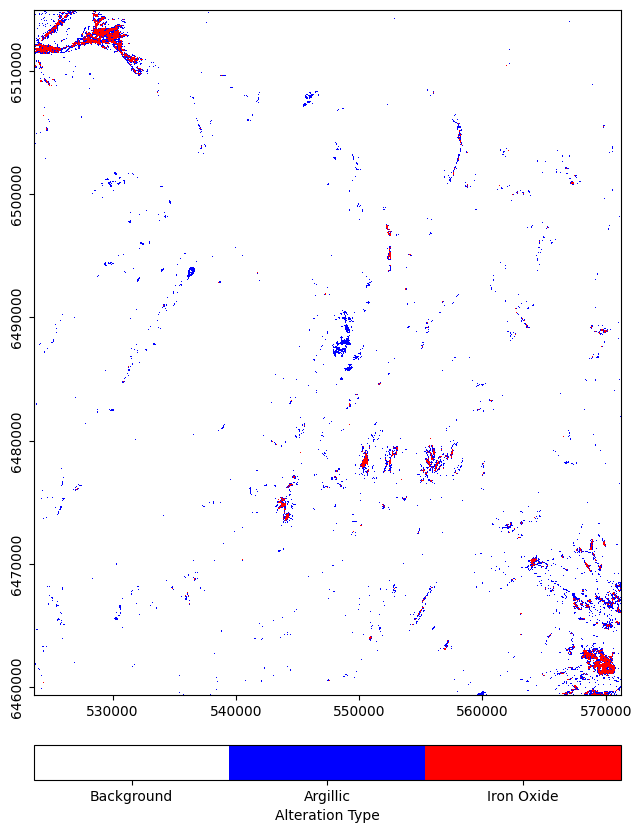

In [13]:
positiveLabel_file = './BrokenHill_Landsat8_PCA_CombinedTraining.tif'
# read and reshape the label file
dsPositiveLabels, arrPositiveLabels = raster.read(positiveLabel_file)
n_class_pos = len(np.unique(arrPositiveLabels))

fig, ax = plt.subplots(figsize=(10, 10))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
cmap = mpl.colors.ListedColormap(['white', 'blue', 'red'])
image = plt.imshow(arrPositiveLabels, cmap=cmap, extent=extent)
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
cbar = plt.colorbar(image, orientation='horizontal', label='Alteration Type', cax=cax)
tick_locs = (np.arange(n_class_pos) + 0.5)*(n_class_pos-1)/n_class_pos
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(['Background', 'Argillic', 'Iron Oxide'])
plt.grid(False)

### Generating random samples

In [14]:
# generate random samples
nonZero_count = np.count_nonzero(arrPositiveLabels)
index = np.transpose(np.where(arrPositiveLabels==0))
index = index.astype(int)
randomIndex = random.sample(range(index.shape[0]), int(nonZero_count/(n_class_pos-1)))
arrNegativeLabels = np.zeros(arrPositiveLabels.shape)

for i in range(len(randomIndex)):
    arrNegativeLabels[index[randomIndex[i], 0], index[randomIndex[i], 1]] = n_class_pos # max value of labels plus one which equals n_class
    
arrPositiveLabels_flat = arrPositiveLabels.flatten()
arrNegativeLabels_flat = arrNegativeLabels.flatten()
# separate and balance the classes
positiveFeatures = arrFeatures_fuzzy[arrPositiveLabels_flat!=0]
positiveLabels = arrPositiveLabels_flat[arrPositiveLabels_flat!=0]
negativeFeatures = arrFeatures_fuzzy[arrNegativeLabels_flat==n_class_pos]
negativeLabels = arrNegativeLabels_flat[arrNegativeLabels_flat==n_class_pos]
# combine the balanced features
features = np.concatenate((positiveFeatures, negativeFeatures), axis=0)
labels = np.concatenate((positiveLabels, negativeLabels), axis=0)
# call the function to split the dataset
train_x, train_y, test_x, test_y = train_test_split(features, labels, train_size=0.7)

### Training the model using MLP

In [15]:
# create the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(6, activation='selu', input_shape=(train_x.shape[1], )))
model.add(tf.keras.layers.Dense(5, activation='selu'))
model.add(tf.keras.layers.Dense(4, activation='softmax'))

# print(model.summary())

# run the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.fit(train_x, test_x, epochs=40)
# predict for the test dataset
yTestPredicted = model.predict(train_y)
# calculate and display error metrics
yTestPredicted_ = yTestPredicted.argmax(axis=1)

cMatrix = confusion_matrix(test_y, yTestPredicted_)
pScore = precision_score(test_y, yTestPredicted_, average='micro')
rScore = recall_score(test_y, yTestPredicted_, average='micro')
fscore = f1_score(test_y, yTestPredicted_, average='micro')

print("Confusion matrix:\n", cMatrix)
print("\nP-Score: %.3f, R-Score: %.3f, F-Score: %.3f" % (pScore, rScore, fscore))

Epoch 1/40
2118/2118 [==============================] - 4s 2ms/step - loss: 0.9730 - accuracy: 0.5343
Epoch 2/40
2118/2118 [==============================] - 4s 2ms/step - loss: 0.7462 - accuracy: 0.6768
Epoch 3/40
2118/2118 [==============================] - 4s 2ms/step - loss: 0.4362 - accuracy: 0.8389
Epoch 4/40
2118/2118 [==============================] - 4s 2ms/step - loss: 0.2945 - accuracy: 0.8980
Epoch 5/40
2118/2118 [==============================] - 4s 2ms/step - loss: 0.2443 - accuracy: 0.9142
Epoch 6/40
2118/2118 [==============================] - 4s 2ms/step - loss: 0.2202 - accuracy: 0.9211
Epoch 7/40
2118/2118 [==============================] - 3s 2ms/step - loss: 0.2033 - accuracy: 0.9262
Epoch 8/40
2118/2118 [==============================] - 3s 1ms/step - loss: 0.1875 - accuracy: 0.9335
Epoch 9/40
2118/2118 [==============================] - 3s 2ms/step - loss: 0.1712 - accuracy: 0.9394
Epoch 10/40
2118/2118 [==============================] - 3s 1ms/step - loss: 0.152

### Mapping alteration zones

91947/91947 [==============================] - 92s 1ms/step


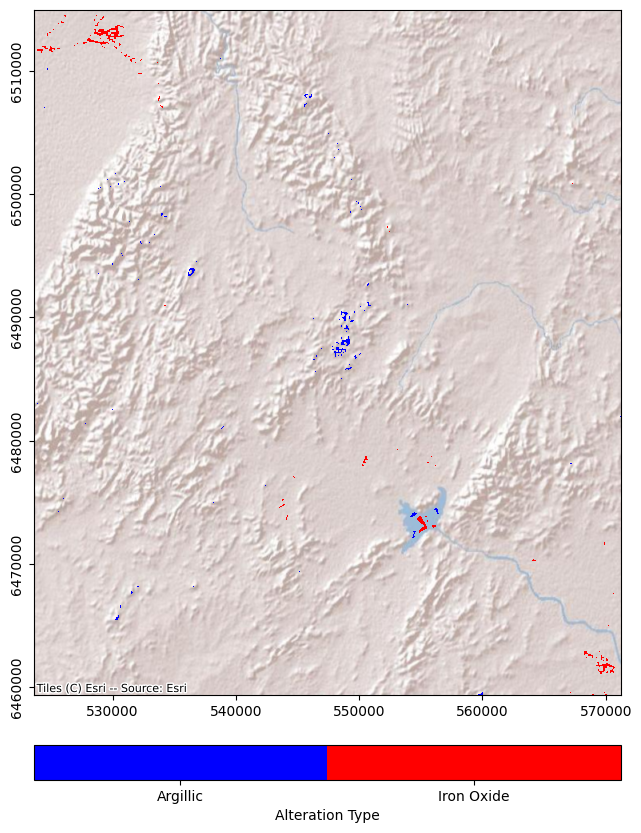

In [16]:
# load and normalize a new multispectral image
dsPred, arrPred = raster.read('./BrokenHill_Landsat8.tif')
arrPred = arrPred.astype(float)
# arrPred = np.float16(arrPred)
arrPred = array_to_table(arrPred)
arrPred_fuzzy = np.zeros(arrPred.shape)

# normalize the image
for i in range(arrPred.shape[1]):
    bandMin = arrPred[:, i].min()
    bandMax = arrPred[:, i].max()
    bandRange = bandMax-bandMin
    for j in range(arrPred.shape[0]):
        arrPred_fuzzy[j, i] = (arrPred[j, i]-bandMin)/bandRange

# predict and export the probability raster
pred = model.predict(arrPred_fuzzy)
pred_array = np.reshape(pred.argmax(axis=1), (dsPred.RasterYSize, dsPred.RasterXSize))

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)
cx.add_basemap(ax, crs='EPSG:32754', source=cx.providers.Esri.WorldShadedRelief)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
cmap = mpl.colors.ListedColormap(['blue', 'red'])

pred_array_copy = pred_array.copy()
pred_array_copy = pred_array_copy.astype('float')
pred_array_copy[pred_array_copy==3] = float('nan')
image = plt.imshow(pred_array_copy, cmap=cmap, extent=extent)

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
cbar = plt.colorbar(image, orientation='horizontal', label='Alteration Type', cax=cax)
tick_locs = (np.arange(n_class_pos-1) + 2.5)*(n_class_pos-2)/(n_class_pos-1)
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(['Argillic', 'Iron Oxide'])
plt.grid(False)

# outFile = './BrokenHill_Landsat8_PCA_MLP_AlterationMap.tif'
# raster.export(pred_array, dsPred, filename=outFile, dtype='float')

### Training the model using SVM

In [17]:
model = SVC()
model.fit(train_x, test_x)
# predict for the test dataset
yTestPredicted = model.predict(train_y)
# calculate and display error metrics
cMatrix = confusion_matrix(test_y, yTestPredicted)
pScore = precision_score(test_y, yTestPredicted, average='micro')
rScore = recall_score(test_y, yTestPredicted, average='micro')
fscore = f1_score(test_y, yTestPredicted, average='micro')

print("Confusion matrix:\n", cMatrix)
print("\nP-Score: %.3f, R-Score: %.3f, F-Score: %.3f" % (pScore, rScore, fscore))

Confusion matrix:
 [[ 6124    18     3]
 [    0 13286     1]
 [  152   248  9208]]

P-Score: 0.985, R-Score: 0.985, F-Score: 0.985


### Mapping alteration zones

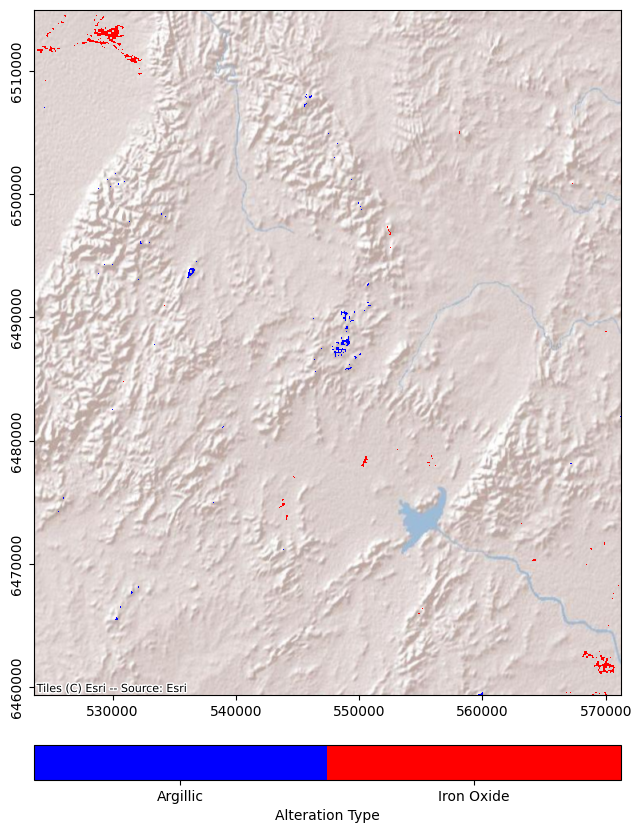

In [18]:
# load and normalize a new multispectral image
dsPred, arrPred = raster.read('./BrokenHill_Landsat8.tif')
arrPred = arrPred.astype(float)
# arrPred = np.float16(arrPred)
arrPred = array_to_table(arrPred)
arrPred_fuzzy = np.zeros(arrPred.shape)

# normalize the image
for i in range(arrPred.shape[1]):
    bandMin = arrPred[:, i].min()
    bandMax = arrPred[:, i].max()
    bandRange = bandMax-bandMin
    for j in range(arrPred.shape[0]):
        arrPred_fuzzy[j, i] = (arrPred[j, i]-bandMin)/bandRange

# predict and export the probability raster
pred = model.predict(arrPred_fuzzy)
pred_array = np.reshape(pred, (dsPred.RasterYSize, dsPred.RasterXSize))

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)
cx.add_basemap(ax, crs='EPSG:32754', source=cx.providers.Esri.WorldShadedRelief)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
cmap = mpl.colors.ListedColormap(['blue', 'red'])

pred_array_copy = pred_array.copy()
pred_array_copy = pred_array_copy.astype('float')
pred_array_copy[pred_array_copy==3] = float('nan')
image = plt.imshow(pred_array_copy, cmap=cmap, extent=extent)

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
cbar = plt.colorbar(image, orientation='horizontal', label='Alteration Type', cax=cax)
tick_locs = (np.arange(n_class_pos-1) + 2.5)*(n_class_pos-2)/(n_class_pos-1)
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(['Argillic', 'Iron Oxide'])
plt.grid(False)

# outFile = './BrokenHill_Landsat8_PCA_SVM_AlterationMap.tif'
# raster.export(pred_array, dsPred, filename=outFile, dtype='float')